In [5]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

import time

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.settings.figdir = 'figures'  # Directory to save figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6)) 

## Step 1: Initialize data

In [6]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'tabula_muris' / 'tabula_muris_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['tissue'],
                    'conditioning_covariate': 'tissue',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
n_cat = len(dataset.id2cov["tissue"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [10]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_train_autoencoder_tabula_muris_whole_genome/df8d1d1a-085d-403c-8323-beb4c5a3f4cd/checkpoints/epoch_79.ckpt"

In [11]:
encoder_model = EncoderModel(in_dim=in_dim, 
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=19734, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=100, bias=True)
    )
  )
  (x_from_x0): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=100, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_runn

## Step 3: Initialize FM model

In [13]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001}

In [14]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_fm_resnet_autoencoder_tabula_muris_whole_genome/ce6b5849-fa72-436b-92ea-881ce0e7be02/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [15]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["tissue"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 2.2524, -0.0400,  0.1449,  ..., -1.9411, -0.0635, -2.0107],
        [-0.1356,  1.6873,  0.1305,  ...,  0.9552, -0.8019, -0.4169],
        [-0.3185,  0.0914,  0.1933,  ..., -1.9906, -0.2986,  0.7978],
        ...,
        [ 0.3369, -0.2165,  0.2448,  ...,  0.6444, -1.7481, -1.7278],
        [ 0.5967,  0.7088,  0.4519,  ..., -0.3613,  0.4684,  0.7139],
        [ 0.9772,  0.1868, -0.7137,  ..., -0.0714,  2.0919,  1.1064]],
       device='cuda:0', requires_grad=True)


Initializations

In [16]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=19734, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
       

# Save three copies of generated datasest 

In [17]:
adata_original = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'tabula_muris' / 'tabula_muris_test.h5ad')
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
saving_dir = DATA_DIR / "generated" / "tabula_muris"

In [ ]:
# index_range = len(adata_original)
# num_indices = 1000

# for it in tqdm(range(3)):
#     X_generated_list = []
#     classes_str = []
#     for _ in range(49):
        
#         # Generate random dummy indices without replacement
#         indices = random.sample(range(index_range), num_indices)
#         adata_indices = adata_original[indices]
        
#         classes =  list(adata_indices.obs.tissue)
#         classes_str += classes
#         classes = torch.tensor([dataset.id2cov["tissue"][c] for  c in classes])
    
#         X_generated = generative_model.batched_sample(batch_size=100,
#                                                         repetitions=10,
#                                                         n_sample_steps=2, 
#                                                         covariate="tissue", 
#                                                         covariate_indices=classes, 
#                                                         log_size_factor=None)
    
#         X_generated_list.append(X_generated.to("cpu"))

#     X_generated_list = torch.cat(X_generated_list, dim=0)
    
#     adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_list).cpu().numpy()))
#     adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
#     adata_generated.obs["tissue"] = classes_str
#     adata_generated.obs["tissue"] = adata_generated.obs["tissue"].astype("category")
#     adata_generated.layers["X_counts"] = adata_generated.X.copy()
#     sc.pp.normalize_total(adata_generated, target_sum=10000)
#     sc.pp.log1p(adata_generated)
#     sc.tl.pca(adata_generated)
#     adata_generated.write_h5ad(f"/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/tabula_muris/generated_cells_{it}.h5ad")

## Time generation

In [32]:
index_range = len(adata_original)
times = []

for it in tqdm(range(3)):  
        
    # Generate random dummy indices without replacement
    indices = random.sample(range(index_range), 49000)
    adata_indices = adata_original[indices]
    
    classes =  list(adata_indices.obs.tissue)
    classes = torch.tensor([dataset.id2cov["tissue"][c] for  c in classes])

    t0 = time.time()
    X_generated = generative_model.batched_sample(batch_size=4900,
                                                    repetitions=10,
                                                    n_sample_steps=2, 
                                                    covariate="tissue", 
                                                    covariate_indices=classes, 
                                                    log_size_factor=None)
    t1 = time.time()
    times.append(t1-t0)

100%|██████████| 3/3 [00:11<00:00,  3.76s/it]


In [33]:
print("Mean generation time", np.mean(times))

Mean generation time 3.6878496011098227


In [34]:
print("Mean generation time", np.std(times)/np.sqrt(3))

Mean generation time 0.13172274821245783


In [35]:
joint_adata = sc.AnnData(X=np.concatenate([adata_original.layers["X_counts"].A, X_generated], axis=0), 
                        obs={"dataset_type": ["real" for _ in range(adata_original.shape[0])] + ["generated" for _ in range(X_generated.shape[0])]})

In [36]:
sc.pp.normalize_total(joint_adata, target_sum=1e4)

In [37]:
sc.pp.log1p(joint_adata)

In [38]:
sc.tl.pca(joint_adata)
sc.pp.neighbors(joint_adata)
sc.tl.umap(joint_adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


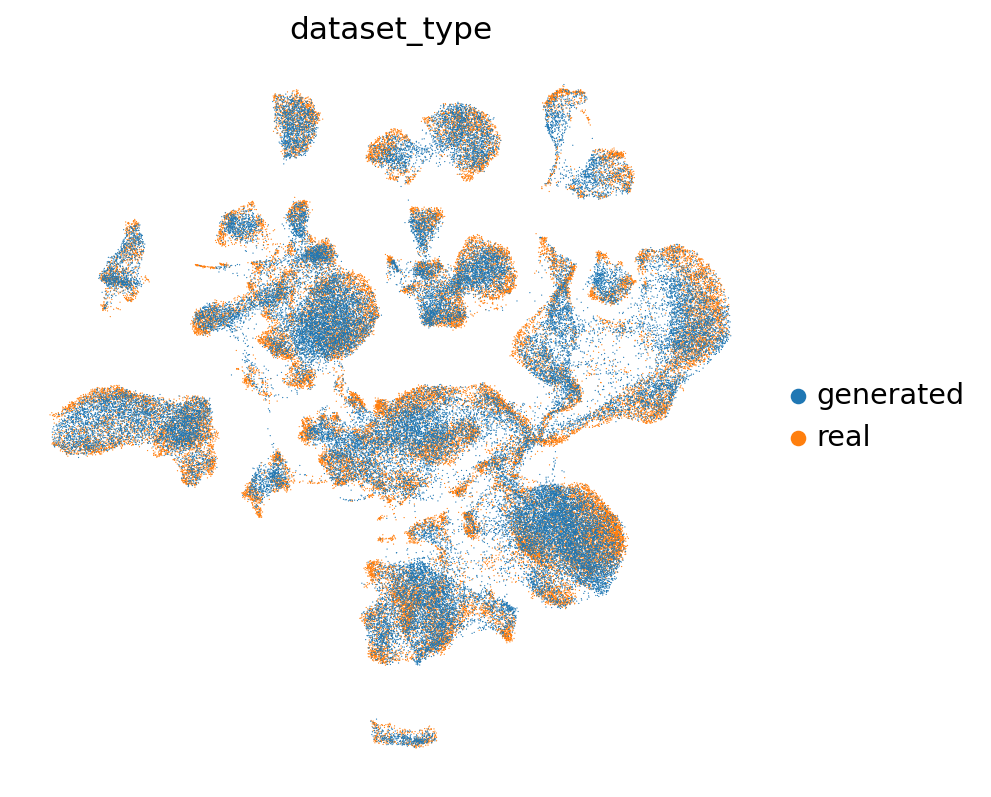

In [39]:
sc.pl.umap(joint_adata, color="dataset_type")